## About

This page showcases the work of Abdoul Madjid, built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative. You can find the original code on his Github repository [here](https://github.com/AbdoulMa), written in [R](https://www.r-graph-gallery.com).

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tomicapretto.github.io/) who translated this work from R to Python! 🙏🙏

Let's see what the final output will look like:

![multipanel line chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-highlighted-lineplot-with-faceting-medium.png?raw=true)


## Load libraries

Today's visualization requires the popular Matplotlib, Numpy, and Pandas trio, as well as the the function [`rankkdata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html) from the `stats` module in [SciPy](https://docs.scipy.org/doc/scipy/reference/). This function is analogous to the R function `rank` and is used to rank an array of values, dealing with ties appropriately.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import rankdata

## Load and prepare the data

The data for this article comes from [Water Point Data Exchange](https://data.waterpointdata.org/dataset/Water-Point-Data-Exchange-WPDx-Basic-/jfkt-jmqa). This guide uses the dataset released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2021-05-04. You can more information in the original announcement [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-05-04/readme.md). Thank you all for making this guide possible!

Let's get started by reading the CSV file from the web.


In [2]:
data_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-04/water.csv")

The first step consists of discarding rows with missing values in the `"install_year"` and `"country_name"` columns, computing the decade in which the water point was installed, and keeping observations between the 1970s and 2020.


In [3]:
data = (
    data_raw
    .dropna(subset=["install_year", "country_name"])
    .assign(
        install_decade=(data_raw["install_year"] // 10) * 10,
    )
    .query("1970 <= install_decade <= 2020")
)

Next, the number of new installations per decade and per country is computed:


In [4]:
data["nb_install"] = data.groupby(["country_name", "install_decade"])[
    "country_name"].transform("size")

The data frame is then manipulated to keep only those countries who have data for all the decades between 1970 and 2020.


In [5]:
data_pivoted = pd.pivot_table(
    data, index="country_name", values="nb_install", columns="install_decade"
).dropna().reset_index()

data = pd.melt(data_pivoted, id_vars="country_name",
               value_name="nb_install", var_name="decade")
data.head()

,country_name,decade,nb_install
0,Ethiopia,1970.0,1.0
1,Ghana,1970.0,566.0
2,Kenya,1970.0,106.0
3,Liberia,1970.0,33.0
4,Nigeria,1970.0,334.0


And finally, we compute the rank for each decade using the negative of the number of new installations. Lower ranks indicate the country has more new installations than the others.


In [6]:
data["country_name"] = data["country_name"].str.upper()
data["rank"] = data.groupby(
    "decade")["nb_install"].transform(lambda x: rankdata(-x))
data = data.sort_values(["country_name", "decade"])
data

,country_name,decade,nb_install,rank
0,ETHIOPIA,1970.0,1.0,12.0
12,ETHIOPIA,1980.0,38.0,11.0
24,ETHIOPIA,1990.0,405.0,11.0
36,ETHIOPIA,2000.0,15132.0,3.0
48,ETHIOPIA,2010.0,4911.0,6.0
...,...,...,...,...
23,ZIMBABWE,1980.0,4055.0,2.0
35,ZIMBABWE,1990.0,5257.0,4.0
47,ZIMBABWE,2000.0,2338.0,8.0
59,ZIMBABWE,2010.0,3334.0,7.0


## Basic lineplot with highlighted line

The chart we aim to reproduce today is made of several subplots, one for each country in the cleaned dataset. It's a good idea to get started by working on just one of those panels before trying to reproduce the whole figure to grab a good understanding of what are the components of the plot and how it's possible to reproduce it.

Let's get started by creating the panel corresponding to the first country, Ethiopia.


In [7]:
COUNTRIES = data["country_name"].unique()
COUNTRY = COUNTRIES[0]

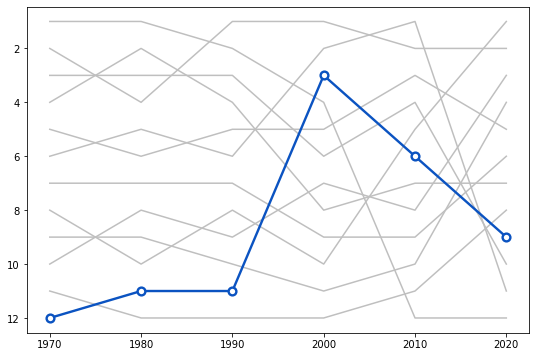

In [8]:
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# From annotations in the original plot we see we have to invert vertical axis
ax.invert_yaxis()

# Loop through countries
for country in COUNTRIES:
    # Filter data to keep rows of the country
    d = data[data["country_name"] == country]
    x = d["decade"].values
    y = d["rank"].values

    # If the country is the selected country, use a thicker blue line and a dot with border
    if country == COUNTRY:
        ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)
        ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12)
    # If not, use a gray and thinner line
    else:
        ax.plot(x, y, color="#BFBFBF", lw=1.5)

# Some notes on the abbreviations:
# ec: edgecolor
# fc: facecolor
# "w": white

Not too bad for a few lines of code! Even though the result is quite discrete, there a couple of concepts to take from this block:

- How to use `zorder`. This argument determines the order in which different components are placed in the plot. If you want something to be on top of another thing, just assign it a larger `zorder` as we do above with the dots.
- A subtle but important component, `ax.invert_yaxis()`. It's possible to see from the original chart that the vertical axis is inverted. This is achieved by simply using the `.invert_yaxis()` method.


## Add title and some annotations

The chart in the first panel also gives information about the ranking. It uses an annotation which contains the rank number, the variable in the vertical axis, and the decade, which is given by the last two digits from the variable in the horizontal axis.

The following is a function adds this annotation to an `Axis` object. The first argument is the value of the decade, and the second value is the rank.

Note that here we also start using custom fonts such as **Lato** and **Inconsolata**. These fonts are freely available from [Google Fonts](https://fonts.google.com/) and can be installed and made available in Matplotlib using the steps in [this guide](https://python-graph-gallery.com/custom-fonts-in-matplotlib).


In [9]:
def add_label(x, y, fontsize, ax):
    PAD = 0.4
    ax.annotate(
        f"#{int(y)} in\n{str(int(x))[2:]}s",
        xy=(x, y - PAD),
        ha="center",
        va="bottom",
        fontsize=fontsize,
        fontname="Lato",
        zorder=12
    )

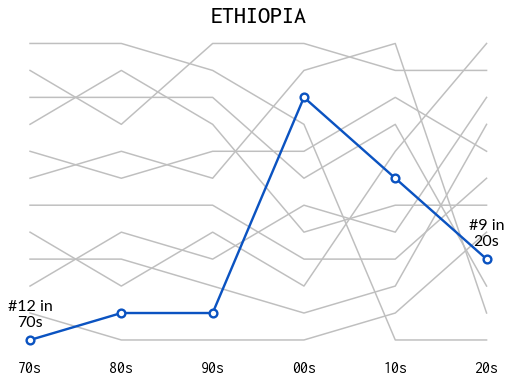

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.invert_yaxis()

for country in COUNTRIES:
    d = data[data["country_name"] == country]
    x = d["decade"].values
    y = d["rank"].values

    if country == COUNTRY:
        ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)
        ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12)

        # Pass the first and last values to the add_label function
        add_label(x[0], y[0], 16, ax)
        add_label(x[-1], y[-1], 16, ax)
    else:
        ax.plot(x, y, color="#BFBFBF", lw=1.5)

# Remove vertical ticks
ax.set_yticks([])

# Set location of horizontal ticks
ax.set_xticks([1970, 1980, 1990, 2000, 2010, 2020])

# Set labels for horizontal ticks
ax.set_xticklabels(
    ["70s", "80s", "90s", "00s", "10s", "20s"],
    fontsize=16,
    fontfamily="Inconsolata"
)
# Remove tick marks in bottom horizontal axis
ax.tick_params(bottom=False)

# Remove the frame
ax.set_frame_on(False)

# Add a title
ax.set_title(COUNTRY, fontfamily="Inconsolata", fontsize=24, fontweight=500)

## Multi panel plot

The original chart is made of many of plots like the one above. We've successfully replicated a single panel (or subplot in Matplotlib's jargon). Everything we've written can be reused in this section.

Let's start by creating a function that contains all the steps required to create the chart above for any country. This function has an argument `annotate` which indicates whether the rank annotations are added or not. This is going to be turned on only for the first panel in the viz.


In [11]:
def plot_country(country, data, annotate, ax):

    for country_inner in COUNTRIES:
        d = data[data["country_name"] == country_inner]
        x = d["decade"].values
        y = d["rank"].values

        if country_inner == country:
            ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)
            ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12)
            if annotate:
                add_label(x[0], y[0], 10, ax)
                add_label(x[-1], y[-1], 10, ax)
        else:
            ax.plot(x, y, color="#BFBFBF", lw=1.5)

    ax.set_yticks([])
    ax.set_xticks([1970, 1980, 1990, 2000, 2010, 2020])
    ax.set_xticklabels(
        ["70s", "80s", "90s", "00s", "10s", "20s"],
        fontsize=10,
        fontfamily="Inconsolata"
    )
    ax.tick_params(bottom=False)
    ax.set_frame_on(False)

    ax.set_title(country, fontfamily="Inconsolata",
                 fontsize=14, fontweight=500)

    return ax

Now, let's loop through the countries, adding a new panel in every iteration step.


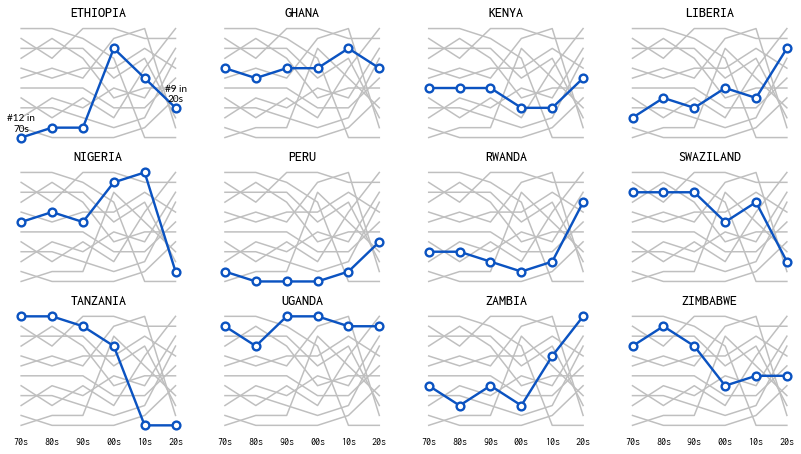

In [12]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 7.5))
for idx, (ax, country) in enumerate(zip(axes.ravel(), COUNTRIES)):
    # Only annotate the first panel
    annotate = idx == 0
    plot_country(country, data, annotate, ax)

# Since sharey=True, all vertical axis are inverted when we invert it in one subplot.
ax.invert_yaxis()

That's cool! Now this is really starting to look like the original chart.


## Add title and caption

The final step is to add the appropiate title and caption. We start by creating some room for these annotations with the `fig.subplots_adjust()` method. This is also where width of the padding between subplots is adjusted. In the end, this chunk also sets the background color.


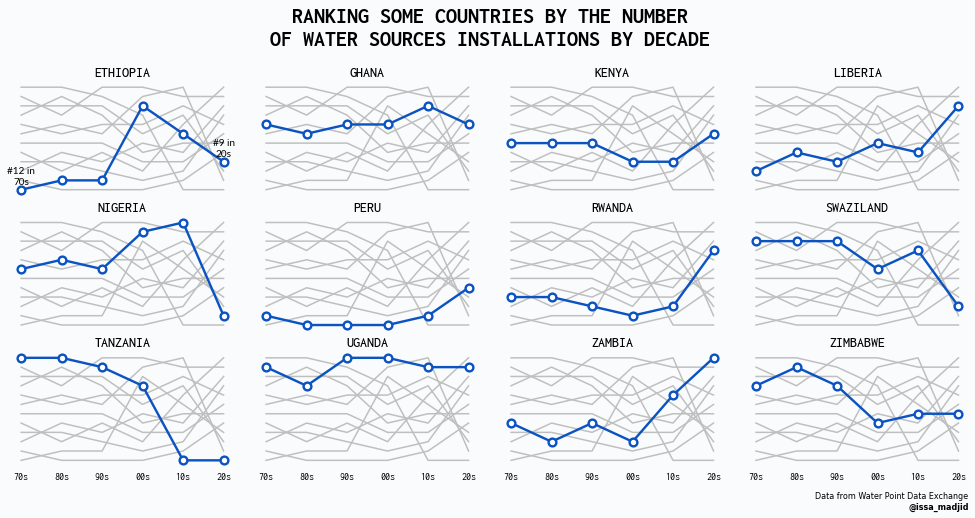

In [13]:
# 1. Adjust horizontal padding
# 2. Decrease both left and right margins
# 3. Customize room in bottom and top.
fig.subplots_adjust(wspace=0.1, left=0.025, right=0.975, bottom=0.11, top=0.82)

# Adds title.
fig.text(
    x=0.5,
    y=0.92,
    s="RANKING SOME COUNTRIES BY THE NUMBER\nOF WATER SOURCES INSTALLATIONS BY DECADE",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold",
    fontname="Inconsolata"
)

# Adds caption
fig.text(
    x=0.975,
    y=0.05,
    s="Data from Water Point Data Exchange",
    ha="right",
    ma="right",
    fontsize=8
)

fig.text(
    x=0.975,
    y=0.03,
    s="@issa_madjid",
    ha="right",
    ma="right",
    fontsize=8,
    fontweight="bold",
)

# Sets background color
fig.set_facecolor("#f9fbfc")

fig

Doesn't it look great?! Simple, elegant, and beatufiul!


## Extra point: Adding Twitter logo

If we really want to reproduce the original chart, we cannot miss the Twitter logo next to Abdoul's Twitter handle. This logo, together with many other logos, can be obtained from the **Font Awesome Brands** fonts that you can download from [here](https://fontawesome.com/v5.15/how-to-use/on-the-desktop/setup/getting-started). Remember you can use [this](https://python-graph-gallery.com/custom-fonts-in-matplotlib) step-by-step guide to install and check the installation of this font.

Next, you can use [this cheatsheet](https://fontawesome.com/v5/cheatsheet/free/brands) to look for the unicode identifier of the Twitter logo, which is **f099**. Do you see how many logos there are? It's great we can now include any of them in our vizualisations!

On the other hand, unfortunately, it's not that easy to mix different font families in Matplotlib as it is in R with the `ggtext` package. But that doesn't mean it's impossible to make it look like we've done so. With a little of trial and error we can tweak the `x` coordinate and place the logo where it looks better.


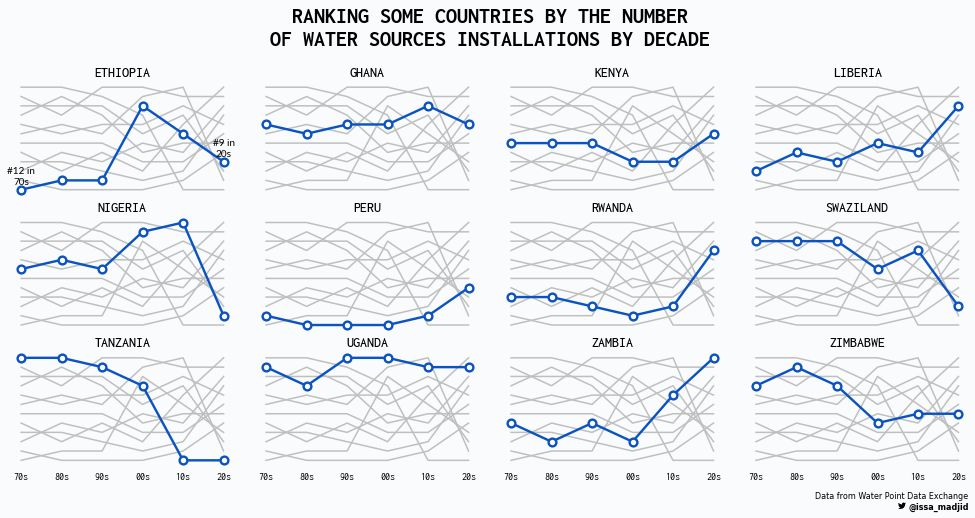

In [14]:
twitter_symbol = "\uf099"

fig.text(
    x=0.912,
    y=0.03,
    s=twitter_symbol,
    ha="right",
    ma="right",
    fontsize=8,
    fontweight="bold",
    fontfamily="Font Awesome 5 Brands"
)


# fig.savefig("plot.png", dpi=300)
fig

<!-- https://stackoverflow.com/questions/52902086/how-to-use-font-awesome-symbol-as-marker-in-matplotlib -->
